In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib, matplotlib.pyplot as plt
from PIL import Image 
from skimage import io
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms, datasets, models
import torch.optim as optim
from collections import Counter
import re
import time
import os
import torch.nn.functional as F
import random

from sklearn.metrics import confusion_matrix, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from itertools import cycle

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
def setup_seed(seed): 
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    np.random.seed(seed) 
    random.seed(seed) 
    torch.backends.cudnn.deterministic = True
    return None
setup_seed(0)

In [3]:
data = pd.read_csv('DBT_train_resized.csv', index_col = 0)
data.head()

,PatientID,StudyUID,Label,View,descriptive_path,classic_path,new_path
0,DBT-P02497,DBT-S00143,0,lcc,Breast-Cancer-Screening-DBT/DBT-P02497/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P02497/1.2.826...,Breast-Cancer-Screening-DBT/DBT-P02497/01-01-2...
1,DBT-P02497,DBT-S00143,0,lmlo,Breast-Cancer-Screening-DBT/DBT-P02497/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P02497/1.2.826...,Breast-Cancer-Screening-DBT/DBT-P02497/01-01-2...
2,DBT-P02497,DBT-S00143,0,rcc,Breast-Cancer-Screening-DBT/DBT-P02497/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P02497/1.2.826...,Breast-Cancer-Screening-DBT/DBT-P02497/01-01-2...
3,DBT-P02497,DBT-S00143,0,rmlo,Breast-Cancer-Screening-DBT/DBT-P02497/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P02497/1.2.826...,Breast-Cancer-Screening-DBT/DBT-P02497/01-01-2...
4,DBT-P02449,DBT-S05000,0,lcc,Breast-Cancer-Screening-DBT/DBT-P02449/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P02449/1.2.826...,Breast-Cancer-Screening-DBT/DBT-P02449/01-01-2...


In [4]:
# Oversample 1 class
print('Number of biopsied samples:', np.sum(data['Label'].values))
print('Number of normal samples:', len(data) - np.sum(data['Label'].values))
disease_ratio = np.sum(data['Label'].values) / len(data)
print('Disease Ratio:', disease_ratio)

labels_unique, counts = np.unique(data.Label, return_counts = True)
class_weights = [sum(counts)/c for c in counts]
example_weights = [class_weights[e] for e in data.Label]
sampler = WeightedRandomSampler(example_weights, len(data))

Number of biopsied samples: 143
Number of normal samples: 12760
Disease Ratio: 0.011082693947144074


In [5]:
train_transforms = transforms.Compose([
                                    #transforms.ToPILImage(),
                                    transforms.ToTensor(),
                                    transforms.RandomRotation(20),
                                    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=0.5, saturation=0.5, contrast=0.5),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    #transforms.Resize((224,224))
                                ])
val_transforms = transforms.Compose([transforms.ToTensor(),
                                     #transforms.Resize((224,224))
                                     ])

class DBT_Dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, -1]
        img = io.imread(img_name, as_gray=True)
        #img = np.asarray(img)
        img.astype(float)
        
        img = img - np.mean(img)
        img = img / np.maximum(np.std(img), 10**(-5))
        
        if self.train:
            img_tens = train_transforms(img)
        else:
            img_tens = val_transforms(img)
            
        label = self.df['Label'].iloc[idx]
        #label = self.df.loc[idx,'Label'].astype('int')
        label = torch.tensor(label, dtype=torch.long)
        sample = (img_tens.float(), label)
        
        return sample

In [6]:
bs = 1
train_df_path = 'DBT_train_resized.csv'
val_df_path = 'DBT_val_resized.csv'
test_df_path = 'DBT_test_resized.csv'

train_loader = DataLoader(DBT_Dataset(train_df_path, train=True), batch_size=bs, num_workers=4, pin_memory=True, sampler=sampler, drop_last=True)
val_loader = DataLoader(DBT_Dataset(val_df_path), batch_size=bs, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)
test_loader = DataLoader(DBT_Dataset(test_df_path), batch_size=bs, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

In [100]:
# Load the pretrained model
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

In [20]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [101]:
# Use the model object to select the desired layer
layer = model._modules.get('layer1')

# Set model to evaluation mode
model.eval()
avg = nn.MaxPool2d(56, stride = 1)
def get_vector(img):
    def copy_data(m, i, o):
        #print(o.shape)
        embed.copy_(avg(o).flatten())                 
    embed = torch.zeros(64)
    h = layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(img)
    #model(img)
    h.remove()
    return embed.numpy()

In [102]:
train_embed, train_label = {}, {}
for idx, (sample) in enumerate(train_loader):
    img = sample[0].to(device)
    labels = sample[1].numpy().squeeze(0)#.to(device)
    train_embed[idx] = get_vector(img)
    train_label[idx] = labels
    
test_embed, test_label = {}, {}
for idx, (sample) in enumerate(test_loader):
    img = sample[0].to(device)
    labels = sample[1].numpy().squeeze(0)#.to(device)
    test_embed[idx] = get_vector(img)
    test_label[idx] = labels

In [93]:
rf_train = pd.DataFrame.from_dict(train_embed, orient='index')
rf_test = pd.DataFrame.from_dict(test_embed, orient='index')

label_train = pd.DataFrame.from_dict(train_label, orient='index')
label_test = pd.DataFrame.from_dict(test_label, orient='index')

In [95]:
rf = RandomForestClassifier()
rf.fit(rf_train, list(label_train[0]))
rf_pred = rf.predict(rf_test)
roc_auc_score(label_test[0], rf_pred)

0.5512609649122807

In [28]:
rf = RandomForestClassifier()
rf.fit(rf_train, list(label_train[0]))
rf_pred = rf.predict(rf_test)
roc_auc_score(label_test[0], rf_pred)

0.5614035087719298

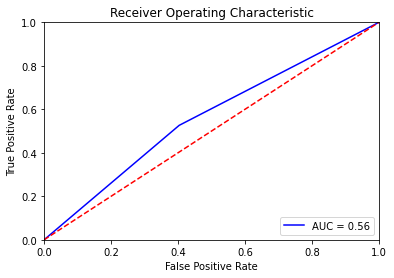

In [39]:
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(label_test[0], rf_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
n_estimators = [350,400,450]
max_depth = [100,150,200]
min_samples_split = [1,2,4]
min_samples_leaf = [1,2,3]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [41]:
print(random_grid)

{'n_estimators': [350, 400, 450], 'max_depth': [100, 150, 200], 'min_samples_split': [1, 2, 4], 'min_samples_leaf': [1, 2, 3]}


In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, scoring='recall', verbose=3, random_state=42, n_jobs=-1)
rf_random.fit(rf_train, list(label_train[0]))

In [72]:
## Best params with full sample
best_params = rf_random.best_params_
best_params

{'n_estimators': 350,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 150}

[CV 2/3] END max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=350;, score=nan total time=   0.1s
[CV 3/3] END max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=400;, score=nan total time=   0.1s
[CV 3/3] END max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=450;, score=nan total time=   0.1s
[CV 1/3] END max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.728 total time= 1.0min
[CV 2/3] END max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=450;, score=0.707 total time= 1.1min
[CV 3/3] END max_depth=100, min_samples_leaf=1, min_samples_split=4, n_estimators=350;, score=0.715 total time=  52.5s
[CV 1/3] END max_depth=100, min_samples_leaf=1, min_samples_split=4, n_estimators=450;, score=0.726 total time= 1.1min
[CV 2/3] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=350;, score=0.707 total time=  49.9s
[CV 2/3] END max_depth=100, min_samples_leaf=2, min_sa

In [54]:
## Best params with 1000 sample bootstrapping
best_params = rf_random.best_params_
best_params

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 150}

In [73]:
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(rf_train, list(label_train[0]))

[CV 1/3] END max_depth=200, min_samples_leaf=3, min_samples_split=4, n_estimators=400;, score=0.717 total time=  56.2s
[CV 2/3] END max_depth=200, min_samples_leaf=3, min_samples_split=4, n_estimators=450;, score=0.704 total time= 1.0min
[CV 3/3] END max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=350;, score=nan total time=   0.1s
[CV 1/3] END max_depth=100, min_samples_leaf=1, min_samples_split=1, n_estimators=450;, score=nan total time=   0.1s
[CV 2/3] END max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=350;, score=0.707 total time=  52.1s
[CV 2/3] END max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.716 total time=  59.9s
[CV 3/3] END max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=450;, score=0.721 total time= 1.1min
[CV 3/3] END max_depth=100, min_samples_leaf=1, min_samples_split=4, n_estimators=400;, score=0.722 total time= 1.0min
[CV 1/3] END max_depth=100, min_samples_leaf=2, min_

RandomForestClassifier(max_depth=150, min_samples_split=4, n_estimators=350)

In [79]:
rf_pred = rf_best.predict(rf_train)

In [76]:
accuracy_score(label_test[0], rf_pred)

0.8941942485078677

In [65]:
## Logistic Regression
lr = LogisticRegression(max_iter=5000)
lr.fit(rf_train, list(label_train[0]))
lr_pred = lr.predict(rf_test)
roc_auc_score(label_test[0], lr_pred)

0.48437500000000006

[CV 2/3] END max_depth=200, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=0.627 total time=   7.4s
[CV 3/3] END max_depth=100, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=0.647 total time=   9.6s
[CV 1/3] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.654 total time=   7.8s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=0.612 total time=   8.3s
[CV 3/3] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.640 total time=   1.8s
[CV 2/3] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.625 total time=   3.9s
[CV 3/3] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.663 total time=   9.3s
[CV 2/3] END max_depth=150, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.632 total time=   4.0s
[CV 3/3] END max_depth=100, min_samples_leaf=1, mi

In [66]:
## SVM
svm = SVC()
svm.fit(rf_train, list(label_train[0]))
svm_pred = svm.predict(rf_test)
roc_auc_score(label_test[0], svm_pred)

0.5016447368421052

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return None

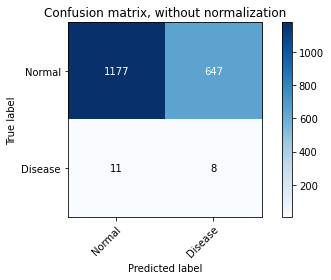

In [20]:
classes = ['Normal','Disease']
plot_confusion_matrix(label_test[0], rf_pred, classes)

In [37]:
roc_auc_score(label_test[0][500:1100], rf_pred[500:1100])

0.6826066008190799

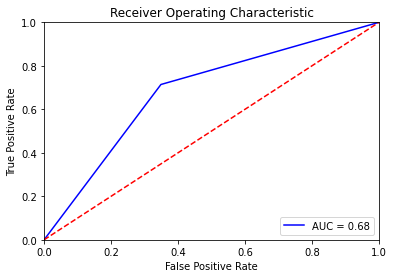

In [47]:
fpr, tpr, threshold = roc_curve(label_test[0][500:1100], rf_pred[500:1100])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

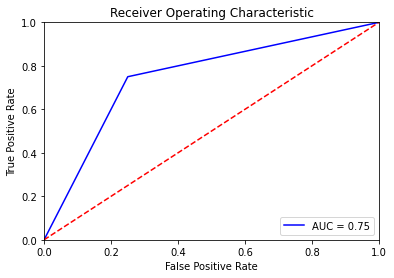

In [75]:
synth = [0]*100+[1]*100
pred = [0]*75+[1]*100+[0]*25
fpr, tpr, threshold = roc_curve(synth, pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [72]:
del auc